In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
# загрузка пакетов: модели -------------------------------------------------
# линейные модели
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
# кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [3]:
# константы
# ядро для генератора случайных чисел
my_seed = 10
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
#sns.color_palette("Set2")

In [4]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/Carseats.csv'
DF_raw = pd.read_csv(fileURL)
DF_raw = DF_raw[['Sales', 'Price', 'Advertising', 'ShelveLoc']]
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 4)


In [5]:
# первые 5 строк фрейма
DF_raw.head(5)

,Sales,Price,Advertising,ShelveLoc
0,9.50,120,11,Bad
1,11.22,83,16,Good
2,10.06,80,10,Medium
3,7.40,97,4,Medium
4,4.15,128,3,Bad


In [6]:
# типы столбцов фрейма
DF_raw.dtypes

,0
Sales,float64
Price,int64
Advertising,int64
ShelveLoc,object


In [7]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

,0
Sales,0
Price,0
Advertising,0
ShelveLoc,0


In [8]:
DF_raw['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [9]:
# добавляем фиктивные на ShelveLoc: число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first=True)
df_dummy.head(5)

,ShelveLoc_Good,ShelveLoc_Medium
0,False,False
1,True,False
2,False,True
3,False,True
4,False,False


In [10]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(400, 6)

In [11]:
# перекодируем ShelveLoc в числовой фактор, чтобы использовать на графиках
class_le = LabelEncoder()
DF_all['ShelveLoc'] = class_le.fit_transform(DF_all['ShelveLoc'].values)

DF_all.columns

Index(['Sales', 'Price', 'Advertising', 'ShelveLoc', 'ShelveLoc_Good',
       'ShelveLoc_Medium'],
      dtype='object')

In [12]:
DF_all.dtypes

,0
Sales,float64
Price,int64
Advertising,int64
ShelveLoc,int64
ShelveLoc_Good,bool
ShelveLoc_Medium,bool


In [13]:
# удаляем фрейм-исходник
del DF_raw

In [14]:
# данные для построения моделей
DF = DF_all.sample(frac = 0.8, random_state = my_seed)
# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

In [15]:
# описательные статистики для непрерывных переменных
DF[['Sales', 'Price', 'Advertising']].describe()

,Sales,Price,Advertising
count,320.000000,320.000000,320.000000
mean,7.525406,114.671875,6.653125
std,2.836775,23.400195,6.594977
min,0.000000,24.000000,0.000000
25%,5.415000,99.000000,0.000000
50%,7.445000,116.000000,5.500000
75%,9.360000,130.250000,12.000000
max,16.270000,191.000000,29.000000


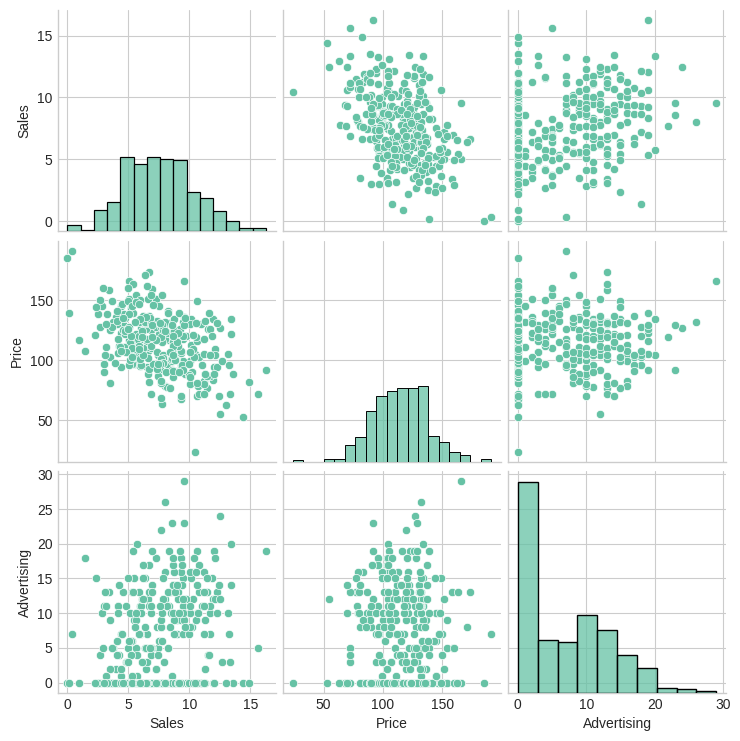

In [16]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Sales', 'Price', 'Advertising']])
plt.show()

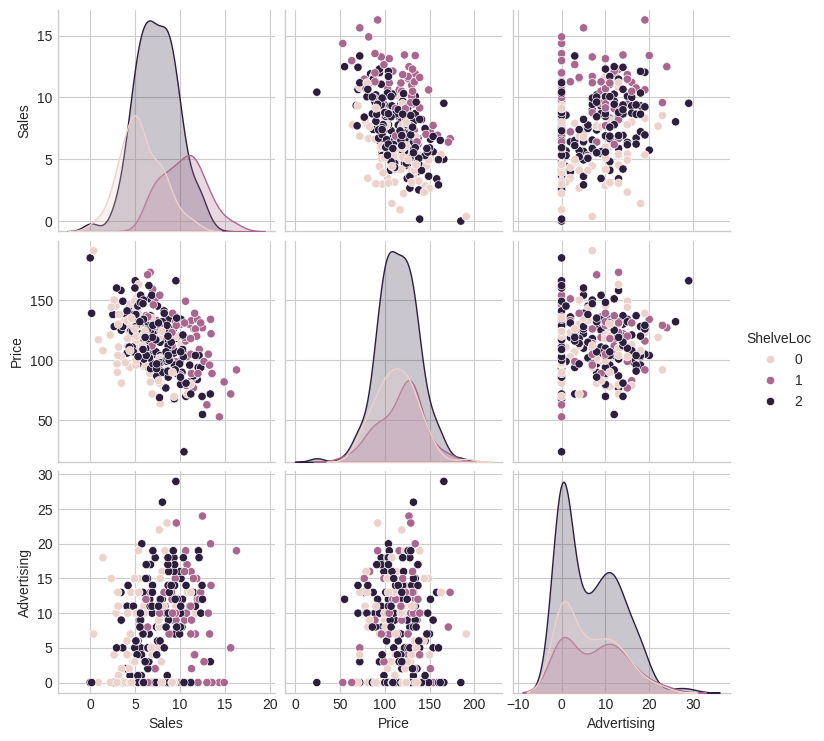

In [17]:
# матричный график разброса с цветом по ShelveLoc
sns.pairplot(DF[['Sales', 'Price', 'Advertising', 'ShelveLoc']], hue='ShelveLoc')
plt.show()

In [18]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Sales', 'Price', 'Advertising']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Sales,Price,Advertising
Sales,1.000000,-0.436681,0.266758
Price,-0.436681,1.000000,0.047544
Advertising,0.266758,0.047544,1.000000


In [19]:
# логарифмируем зависимую переменную
DF['log_Sales'] = np.log(DF['Sales'])
# описательные статистики для непрерывных показателей
DF[['Sales', 'log_Sales', 'Price', 'Advertising']].describe()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Sales,log_Sales,Price,Advertising
count,320.000000,320.000000,320.000000,320.000000
mean,7.525406,-inf,114.671875,6.653125
std,2.836775,NaN,23.400195,6.594977
min,0.000000,-inf,24.000000,0.000000
25%,5.415000,1.689172,99.000000,0.000000
50%,7.445000,2.007542,116.000000,5.500000
75%,9.360000,2.236444,130.250000,12.000000
max,16.270000,2.789323,191.000000,29.000000


In [20]:
# тестируем на нормальность
for col in ['Sales', 'log_Sales']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Sales Statistics=0.99, p=0.3251
Распределение нормально (H0 не отклоняется)

log_Sales Statistics=nan, p=1.0000
Распределение нормально (H0 не отклоняется)



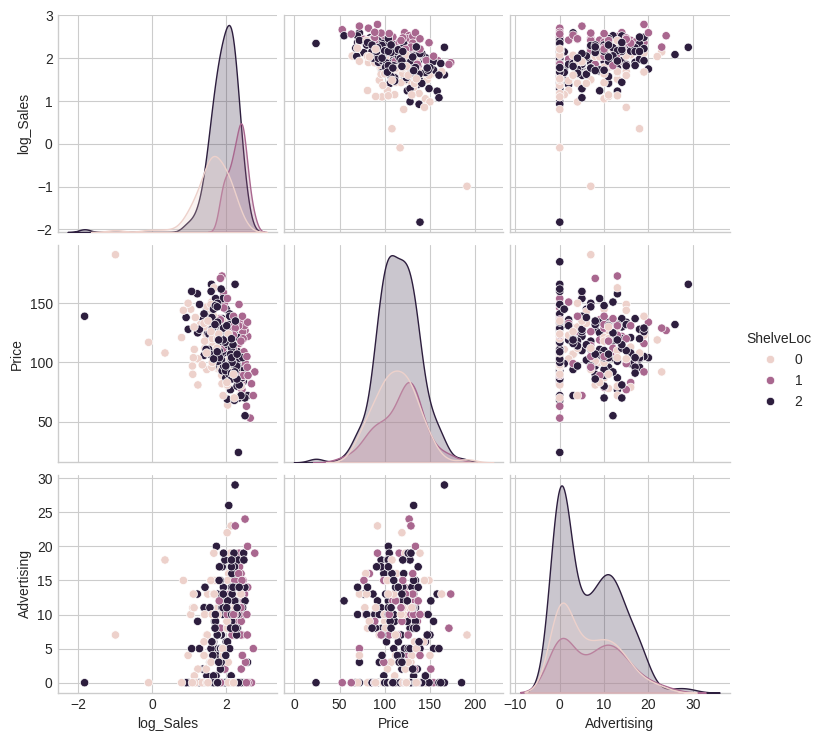

In [21]:
# матричный график разброса с цветом по ShelveLoc
sns.pairplot(DF[['log_Sales', 'Price', 'Advertising', 'ShelveLoc']], hue='ShelveLoc')
plt.show()

In [22]:
df0 = DF.drop(['log_Sales'], axis=1).copy()

df1 = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()

df2 = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
df2['Price_ShelveLoc_Good'] = df2['Price'] * df2['ShelveLoc_Good']

df3 = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
df3['Advertising_ShelveLoc_Good'] = df3['Advertising'] * df3['ShelveLoc_Good']

df4 = DF[['Sales', 'Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
df4['Price_ShelveLoc_Good'] = df4['Price'] * df4['ShelveLoc_Good']
df4['Advertising_ShelveLoc_Good'] = df4['Advertising'] * df4['ShelveLoc_Good']

In [23]:
# загрузка пакетов: модели ---
# линейные модели
import sklearn.linear_model as skl
# расчёт MSE
from sklearn.metrics import mean_squared_error
# кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [24]:
# LOOCV для моделей с Sales
lm = skl.LinearRegression()
loo = LeaveOneOut()

scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4]:
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    score = cross_val_score(lm, X, y, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 10.65 секунд


In [25]:
# модели для log_Sales
scores_log = list()
# таймер
tic = time.perf_counter()

# Создаем логарифмированные датафреймы ПРАВИЛЬНО
original_dfs = [df0, df1, df2, df3, df4]
log_dfs = []

for i, df in enumerate(original_dfs):
    df_log = df.copy()
    # Логарифмируем значения Sales
    if DF['Sales'].min() <= 0:
        # Если есть нулевые или отрицательные значения, добавляем константу
        df_log['Sales'] = np.log(df['Sales'] + 1e-8)
    else:
        df_log['Sales'] = np.log(df['Sales'])
    log_dfs.append(df_log)

# Присваиваем переменным
df0_log, df1_log, df2_log, df3_log, df4_log = log_dfs




# Выполняем кросс-валидацию
for df in [df0_log, df1_log, df2_log, df3_log, df4_log]:
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    score = cross_val_score(lm, X, y, cv=loo, scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")



Расчёты методом LOOCV заняли 8.07 секунд


In [26]:
[np.around(-x, 3) for x in scores_log]

[np.float64(1.384),
 np.float64(1.384),
 np.float64(1.385),
 np.float64(1.383),
 np.float64(1.384)]

In [27]:
# самая точная на Sales
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))],
      '!\nMSE_loocv =', np.around(-max(scores), 2))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 !
MSE_loocv = 3.33


In [28]:
# самая точная на log(Sales)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))],
      '!\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_3_log !
MSE_loocv = 1.383


In [29]:
# прогноз по лучшей модели на отложенные наблюдения
# определяем лучшую модель
best_model_name = fits[scores_log.index(max(scores_log))]
print(f'Лучшая модель: {best_model_name}')

# строим лучшую модель на всех обучающих наблюдениях
if best_model_name == 'fit_lm_0_log':
    X_train = df0_log.drop(['Sales'], axis=1)
    y_train = df0_log.Sales.values.reshape(-1, 1)
    fit_best = lm.fit(X_train, y_train)
    X_test = DF_predict.drop(['Sales'], axis=1)
    y_test = np.log(DF_predict.Sales.values.reshape(-1, 1))

elif best_model_name == 'fit_lm_1_log':
    X_train = df1_log.drop(['Sales'], axis=1)
    y_train = df1_log.Sales.values.reshape(-1, 1)
    fit_best = lm.fit(X_train, y_train)
    X_test = DF_predict[['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']]
    y_test = np.log(DF_predict.Sales.values.reshape(-1, 1))

elif best_model_name == 'fit_lm_2_log':
    X_train = df2_log.drop(['Sales'], axis=1)
    y_train = df2_log.Sales.values.reshape(-1, 1)
    fit_best = lm.fit(X_train, y_train)
    X_test = DF_predict[['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
    X_test['Price_ShelveLoc_Good'] = X_test['Price'] * X_test['ShelveLoc_Good']
    y_test = np.log(DF_predict.Sales.values.reshape(-1, 1))

elif best_model_name == 'fit_lm_3_log':
    X_train = df3_log.drop(['Sales'], axis=1)
    y_train = df3_log.Sales.values.reshape(-1, 1)
    fit_best = lm.fit(X_train, y_train)
    X_test = DF_predict[['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
    X_test['Advertising_ShelveLoc_Good'] = X_test['Advertising'] * X_test['ShelveLoc_Good']
    y_test = np.log(DF_predict.Sales.values.reshape(-1, 1))

elif best_model_name == 'fit_lm_4_log':
    X_train = df4_log.drop(['Sales'], axis=1)
    y_train = df4_log.Sales.values.reshape(-1, 1)
    fit_best = lm.fit(X_train, y_train)
    X_test = DF_predict[['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium']].copy()
    X_test['Price_ShelveLoc_Good'] = X_test['Price'] * X_test['ShelveLoc_Good']
    X_test['Advertising_ShelveLoc_Good'] = X_test['Advertising'] * X_test['ShelveLoc_Good']
    y_test = np.log(DF_predict.Sales.values.reshape(-1, 1))

# прогноз
y_pred = fit_best.predict(X_test)
# Для логарифмированных моделей нужно преобразовать обратно в исходную шкалу
MSE_test = sum((np.exp(y_test) - np.exp(y_pred.reshape(-1, 1)))**2) / len(y_test)
print(f'MSE на тестовой выборке: {np.around(MSE_test, 2)}')

Лучшая модель: fit_lm_3_log
MSE на тестовой выборке: [8.54]


In [30]:
# интерпретация параметров лучшей модели
print('Лучшая модель:', best_model_name)
print('Константа:', np.around(fit_best.intercept_, 3))
print('Объясняющие переменные:', list(X_train.columns.values))
print('Коэффициенты:', np.around(fit_best.coef_, 3))

Лучшая модель: fit_lm_3_log
Константа: [3.37]
Объясняющие переменные: ['Price', 'Advertising', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Advertising_ShelveLoc_Good']
Коэффициенты: [[-0.017  0.03   0.87   0.221 -0.019]]
